# Анализ результатов A/B-теста в интернет-магазине

Международный интернет-магазин внедряет улучшенную рекомендательную систему. Необходимо провести оценку результатов A/B-теста и сформулировать заключение об эффективности новой системы.

**Техническое задание:**

* Название теста: recommender_system_test
* группы: А — контрольная, B — новая платёжная воронка
* дата запуска: 2020-12-07
* дата остановки набора новых пользователей: 2020-12-21
* дата остановки теста: 2021-01-04
* аудитория: 15% новых пользователей из региона EU
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
* ожидаемое количество участников теста: 6000
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут   улучшение каждой метрики не менее, чем на 10%:
  * конверсии в просмотр карточек товаров — событие product_page
  * просмотры корзины — product_cart
  * покупки — purchase

**В нашем распоряжении следующие данные:**

Календарь маркетинговых событий на 2020 год - **final_ab_marketing_events**:

* name — название маркетингового события
* regions — регионы, в которых будет проводиться рекламная кампания
* tart_dt — дата начала кампании
* finish_dt — дата завершения кампании

Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020г. - **final_ab_new_users**:

* user_id — идентификатор пользователя
* first_date — дата регистрации
* region — регион пользователя
* device — устройство, с которого происходила регистрация

Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021г. - **final_ab_events**:

* user_id — идентификатор пользователя
* event_dt — дата и время покупки
* event_name — тип события
* details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах

Таблица участников теста - **final_ab_participants:**

* user_id — идентификатор пользователя
* ab_test — название теста
* group — группа пользователя

# 1. Обзор данных 

In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import stats
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from datetime import datetime, timedelta
from termcolor import colored
from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

In [136]:
users = pd.read_csv('10_final_ab_new_users.csv')
ab_events = pd.read_csv('10_final_ab_events.csv')
marketing_events = pd.read_csv('10_final_ab_marketing_events.csv')
ab_participants = pd.read_csv('10_final_ab_participants.csv')

In [137]:
def df_info(df):
  print(df.info())
  display(df.head())
  display(df.describe())
  print('Пропущенные значения:')
  print(df.isna().sum())
  print('Дубликаты', df.duplicated().sum())

In [138]:
# пользователи A/B-теста
df_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,4F73A97FCC4212A2,2020-12-21,EU,Android
freq,1,6290,46270,27520


Пропущенные значения:
user_id       0
first_date    0
region        0
device        0
dtype: int64
Дубликаты 0



**Выводы:**

* всего 61733 пользователя
* 4 региона
* 4 типа устройства
* пропусков и дубликатов нет

Необходимо:

* изменить тип поля first_date на datetime

In [139]:
# данные о поведении пользователей A/B-теста:
df_info(ab_events)
print('\nСобытия:', ab_events['event_name'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Пропущенные значения:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Дубликаты 0

События: ['purchase' 'product_cart' 'product_page' 'login']


**Выводы:**

* всего 440317 событий
* 4 типа событий
* пропуски встречаются только в поле details (377577), что допустимо

Необходимо:

* изменить тип поля event_dt на datetime

In [140]:
# календарь маркетинговых событий:
display(marketing_events)
print(marketing_events.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None



**Выводы:**

после набора пользователей, но до остановки теста, в период с 25.12.2020 по 03.01.2021гг. в EU проводилась акция "Christmas&New Year Promo", которая могла повлиять на исследуемые метрики - необходимо учесть это при анализе.

In [141]:
# таблица участников теста:
df_info(ab_participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,4F26C1C82B9EA0B5,A,interface_eu_test
freq,2,9655,11567


Пропущенные значения:
user_id    0
group      0
ab_test    0
dtype: int64
Дубликаты 0



**Выводы:**

* всего 18268 пользователей и 2 теста
* пропущенных значений и дублей нет

# 2. Предобработка данных

In [142]:
def to_dttime(df, param, frmt):
  try:
    df[param] = pd.to_datetime(df[param], format=frmt)
  except:
    print('Проверьте корректность введенных данных в поле', param)


In [143]:
# Заменим тип данных на datetime там, где это нужно:

to_dttime(users, 'first_date', '%Y-%m-%d')
to_dttime(ab_events, 'event_dt', '%Y-%m-%d %H:%M:%S')

# 3. Проверка корректности проведения теста  

**3.1. Проверим соблюдение правил набора пользователей и сроков проведения теста**

In [144]:
print('Набор пользователей: с', users['first_date'].min(), 'по', users['first_date'].max())
print('Данные о событиях: с', ab_events['event_dt'].min(), 'по', ab_events['event_dt'].max())

Набор пользователей: с 2020-12-07 00:00:00 по 2020-12-23 00:00:00
Данные о событиях: с 2020-12-07 00:00:33 по 2020-12-30 23:36:33



* В таблицу users попали пользователи, зарегистрировавшиеся после 21.12.2020г.
* В таблице ab_events нет данных о событиях с 31.12.2020 по 04.01.2021 (время остановки теста). Не хватает информации за 5 дней из 28 запланированных - почти 18% данных не доступны для анализа, что может исказить результаты исследования.

**3.2. Проверим количество участников теста**

In [145]:
ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [146]:
ab_participants.groupby(['ab_test','group']).agg({'user_id':'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

Оказывается, параллельно с нашим тестом, шёл другой, причём, довольно масштабный. Проверим, насколько пересеклись аудитории тестов:

In [147]:
ntests_per_user = ab_participants.groupby('user_id').agg({'ab_test': 'nunique'}).sort_values(by = 'ab_test', ascending = False).reset_index()
print('Пользователей, попавших в оба теста:', ntests_per_user[ntests_per_user['ab_test'] > 1]['user_id'].count())

Пользователей, попавших в оба теста: 1602


Исключим данных пользователей из рассмотрения и снова оценим количество участников теста:

In [148]:
test_participants = ab_participants[~ab_participants['user_id'].isin(ntests_per_user[ntests_per_user['ab_test'] > 1]['user_id'].values)]

# Оставляем пользователей только нашего теста:
test_participants = test_participants[test_participants['ab_test'] == 'recommender_system_test']

test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A         2903
                        B         2196

* Количество участников в группах А и В сильно различается, что может исказить результаты.
* Общее количество участников теста меньше ожидаемого на 15% (5099 против 6000), что также может исказить результаты.

Проверим, есть ли пользователи, попавшие сразу в две группы:

In [149]:
t = test_participants.groupby('user_id').agg(group_count = ('group', 'nunique'))
print('Пользователей, попавших одновременно в группу А и группу В:', len(t[t['group_count'] > 1]))

Пользователей, попавших одновременно в группу А и группу В: 0


Исключим из остальных данных всё, что не касается участников нашего теста.

In [150]:
# В пользователях оставим участников только нашего теста:
test_users = users[users['user_id'].isin(test_participants['user_id'])]

# Добавим информацию о группе, в которую попал каждый пользователь:
test_users = test_users.merge(test_participants, on = 'user_id')

Посмотрим, в каких регионах находятся участники нашего теста:

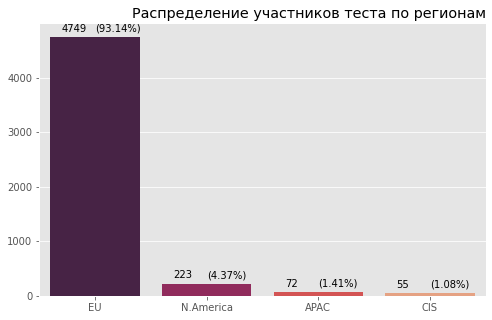

In [151]:
plt.figure(figsize=(8, 5))
plt.title('Распределение участников теста по регионам', loc='right')
sns.countplot(x = test_users['region'], order = test_users['region'].value_counts().index, palette='rocket')

for i, v in enumerate(-np.sort(-test_users.groupby('region')['user_id'].count().values)):
    plt.text(i - 0.3, v + 100, str(v), color='black', fontsize = 10)
    plt.text(i, v + 100, '({:.2%})'.format(v / test_users['user_id'].nunique()), color='black', fontsize = 10)

sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.show()

* Большинство участников находится в нужном регионе (EU). Небольшая доля других регионов допустима, т.к. объясняется перелётами, использованием VPN, анонимайзеров и пр.

Проверим аудиторию нашего теста. Согласно ТЗ, она должна содержать 15% всех новых пользователей из региона EU.

In [152]:
eu_test_users = test_users[test_users['region'] == 'EU'].shape[0]
eu_users = users[(users['region'] == 'EU') & (users['first_date'] >= pd.to_datetime('2020-12-07')) & (users['first_date'] <= pd.to_datetime('2021-01-04'))].shape[0]
print('Доля пользователей из EU - участников теста: {:.1%}'.format(eu_test_users / eu_users))


Доля пользователей из EU - участников теста: 10.3%


* После исключения пользователей, попавших в оба теста одновременно, у нас осталось только 10% европейцев против запланированных 15%, что может исказить результаты теста

Оставим в таблице с событиями действия, совершённые участниками только нашего теста:

In [153]:
# События, совершённые участниками нашего теста:
test_events = ab_events[ab_events['user_id'].isin(test_participants['user_id'])]

# Добавим информацию о группе, в которую попал каждый пользователь:
test_events = test_events.merge(test_participants, on = 'user_id')

In [154]:
ntest_users = test_users['user_id'].nunique()
ntest_events = test_events['user_id'].nunique()

print('Количество участников теста:', ntest_users)
print('Количество уникальных пользователей, совершавших действия в системе:', ntest_events)
print('\033[1m' + colored('Доля участников теста, не совершивших ни одного действия в системе: {:.1%}'.format((ntest_users-ntest_events)/ntest_users), 'red'))

Количество участников теста: 5099
Количество уникальных пользователей, совершавших действия в системе: 2788
Доля участников теста, не совершивших ни одного действия в системе: 45.3%



Посмотрим на распределение активных участников теста по группам:

In [155]:
test_events.groupby('group').agg(users = ('user_id', 'nunique'))

,users
group,
A,2082
B,706


**Проверка корректности проведения теста. Выводы**

Тест был проведён со множеством нарушений:

* После набора пользователей, но до остановки теста, в период с 25.12.2020 по 03.01.2021гг. в EU проводилась акция "Christmas&New Year Promo".
* В выгрузке нет данных о событиях с 31.12.2020 по 04.01.2021 (время остановки теста). Не хватает информации за 5 дней из 28 запланированных - почти 18% данных не доступны для анализа.
* Параллельно с нашим тестом шёл другой масштабный тест. После исключения из анализа участников, попавших в оба теста, всего осталось 5099 пользователей, что на 15% меньше от запланированного количества.
* Количество участников в группах А и В сильно различается (2903 и 2196, соответственно).
* Аудитория теста составила 10% новых пользователей из EU против запланированных 15%.
* Почти половина пользователей теста (45.3%) не совершили ни одного действия в системе. Активных пользователей в группе А оказалось почти в 3 раза больше, чем в группе В (2082 против 706).

# 4. Исследовательский анализ данных. Оценка метрик 

**4.1. Воронка событий**

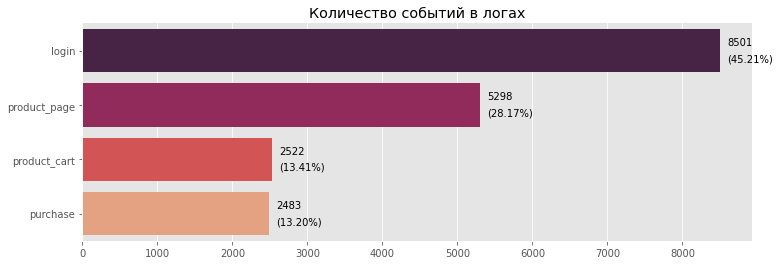

In [156]:
# Сгруппируем логи по событиям и посмотрим на их количество:
events = test_events.groupby('event_name').agg(count = ('user_id', 'count')).sort_values('count', ascending=False).reset_index()
#display(events)

plt.figure(figsize=(12, 4))
plt.title('Количество событий в логах')
sns.barplot(y=events['event_name'], x=events['count'], palette='rocket', orient='h')

for i, v in enumerate(events['count'].values):
    plt.text(v + 100, i - 0.1, str(v), color='black', fontsize = 10)
    plt.text(v + 100, i + 0.2, '({:.2%})'.format(v / events['count'].sum()), color='black', fontsize = 10)

plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.show()


* Авторизовались (login) 8501 раз
* Продающий экран (product_page) увидели 5298 раз
* Корзину (product_cart) увидели 2522 раза
* Оформили покупку (purchase) 2483 раза

Посчитаем, сколько уникальных пользователей совершали эти события.

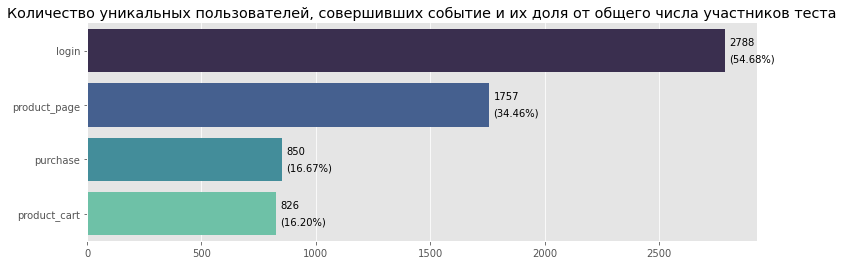

In [157]:
users_per_event = test_events.groupby('event_name').agg(users=('user_id','nunique')).sort_values('users', ascending=False).reset_index()

plt.figure(figsize=(12, 4))
plt.title('Количество уникальных пользователей, совершивших событие и их доля от общего числа участников теста')
sns.barplot(y=users_per_event['event_name'], x=users_per_event['users'], palette='mako', orient='h')

for i, v in enumerate(users_per_event['users'].values):
    plt.text(v + 20, i - 0.1, str(v), color='black', fontsize = 10)
    plt.text(v + 20, i + 0.2, '({:.2%})'.format(v / test_users['user_id'].nunique()), color='black', fontsize = 10)
    
plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.show()

* Авторизовались 2788 пользователей (55% от общего числа участников теста)
* Страницу товара просмотрели 1757 пользователей (35% от общего числа)
* Страницу товара просмотрели 826 пользователей (16% от общего числа)
* Оформили заказ 850 пользователей (17% от общего числа)

Видимо, оформить заказ можно минуя корзину.

Посмотрим на эти же данные, только с разбивкой по тестовым группам, чтобы сравнить конверсию в шаги воронки по группам.

In [158]:
users_per_event = (test_events.groupby(['event_name','group'])
                   .agg(users=('user_id','nunique'))
                   .sort_values('users', ascending=False)
                   .reset_index())

fig = go.Figure()

fig.update_layout(title_text='Конверсия в шаги воронки по группам А и В')

fig.add_trace(go.Funnel(
    name = 'A',
    y = users_per_event[users_per_event['group']=='A']['event_name'],
    x = users_per_event[users_per_event['group']=='A']['users'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = users_per_event[users_per_event['group']=='B']['event_name'],
    x = users_per_event[users_per_event['group']=='B']['users'],
    textinfo = "value+percent previous"))

fig.show()

* Группа В проигрывает группе А в конверсии на первом шаге (-9%), но выигрывает на втором (+2%) и третьем (+1%)

Воронка продаж с учётом последовательности событий


Рассмотрим конверсию в шаги воронки с учётом их последовательности.

In [159]:
def funnel_data(test_group, steps, step_names):
    """ Функция строит и возвращает датафрейм для построения воронки с учётом последовательности шагов.
        Входные параметры:
        `test_group` - название тестовой группы
        `steps` - шаги, по которым будет строится воронка
        `step_names` - наименования шагов для отображения на графике 
    """
    users = test_events[test_events['group'] == test_group].pivot_table(index='user_id', columns='event_name', values='event_dt', aggfunc='min')
        
    step_1 = ~users[steps[0]].isna() 
    n_users = [users[step_1].shape[0]]
    
    if len(steps) > 1: 
        step_2 = step_1 & (users[steps[1]] >= users[steps[0]])
        n_users.append(users[step_2].shape[0])
    
    if len(steps) > 2:
        step_3 = step_2 & (users[steps[2]] >= users[steps[1]])
        n_users.append(users[step_3].shape[0])
    
    if len(steps) > 3:
        step_4 = step_3 & (users[steps[3]] >= users[steps[2]])
        n_users.append(users[step_4].shape[0])
    
    df_test_group = pd.DataFrame(dict(number=n_users, stage=step_names))
    df_test_group['group'] = test_group

    return df_test_group

In [160]:

def show_funnel(steps, step_names):
    """
    Функция строит воронку с учётом последовательности шагов.
    Входные параметры:
    `steps` - шаги, по которым будет строится воронка
    `step_names` - наименования шагов для отображения на графике     
    """
    a = funnel_data('A', steps, step_names)
    b = funnel_data('B', steps, step_names)

    fig = go.Figure()

    fig.update_layout(title_text='Пользователи, прошедшие по этапам воронки')

    fig.add_trace(go.Funnel(
        name = 'A',
        y = a['stage'],
        x = a['number'],
        textinfo = "value+percent initial"))

    fig.add_trace(go.Funnel(
        name = 'B',
        y = b['stage'],
        x = b['number'],
        textinfo = "value+percent initial"))

    fig.show()

Вероятная последовательность событий, ведущая к продаже, выглядит так:

* Авторизация
* Просмотр товара
* Просмотр корзины
* Оформление покупки

In [161]:
show_funnel(['login','product_page','product_cart','purchase'], ['Авторизовались', 'Просмотрели товар', 'Просмотрели корзину', 'Оформили покупку'])

* Только 45 пользователей прошли по каждому шагу воронки. Учитывая, что всего оформлено 850 покупок, большинство пользователей шли к оплате какими-то иными путями. Попробуем выяснить какими.

In [162]:
test_events.sort_values(['user_id', 'event_dt']).head(20)

,user_id,event_dt,event_name,details,group,ab_test
4425,0010A1C096941592,2020-12-17 21:07:27,purchase,4.99,A,recommender_system_test
4429,0010A1C096941592,2020-12-17 21:07:27,product_page,NaN,A,recommender_system_test
4433,0010A1C096941592,2020-12-17 21:07:27,login,NaN,A,recommender_system_test
4426,0010A1C096941592,2020-12-19 04:34:37,purchase,4.99,A,recommender_system_test
4434,0010A1C096941592,2020-12-19 04:34:37,login,NaN,A,recommender_system_test
4430,0010A1C096941592,2020-12-19 04:34:38,product_page,NaN,A,recommender_system_test
4427,0010A1C096941592,2020-12-21 21:05:23,purchase,4.99,A,recommender_system_test
4435,0010A1C096941592,2020-12-21 21:05:23,login,NaN,A,recommender_system_test
4431,0010A1C096941592,2020-12-21 21:05:24,product_page,NaN,A,recommender_system_test
4428,0010A1C096941592,2020-12-23 11:52:09,purchase,9.99,A,recommender_system_test


Можно заметить, что оформление покупки purchase происходит одновременно с событием login. Просмотр корзины и/или карточки товара происходит или одновременно с покупкой, или позже неё.

Посмотрим на воронку по шагам, где Оплата происходит раньше просмотра Товара или Корзины:

In [163]:
show_funnel(['login', 'purchase', 'product_page'], ['Авторизовались', 'Оформили покупку', 'Просмотрели товар'])

In [164]:
show_funnel(['login', 'purchase', 'product_cart'], ['Авторизовались', 'Оформили покупку', 'Просмотрели корзину'])


И обратно:

In [165]:
show_funnel(['purchase', 'login'], ['Оформили покупку', 'Авторизовались'])


In [166]:
show_funnel(['product_page', 'purchase'], ['Просмотр товара', 'Оформили покупку'])


In [167]:
show_funnel(['product_cart', 'purchase'], ['Просмотр корзины', 'Оформили покупку'])


* 845 пользователей, совершивших покупку, сделали это одновременно с авторизацией.
* 5 пользователей оформили заказ без авторизации.
* одномоментно или сразу после оформления покупки и авторизации пользователю показывается карточка товара либо корзина.
* группа В уступает группе А в конверсии почти на каждом шаге воронки (впрочем, всего на несколько процентов).

**4.2. Распределение событий** 

Посчитаем среднее количество событий на пользователя по группам.

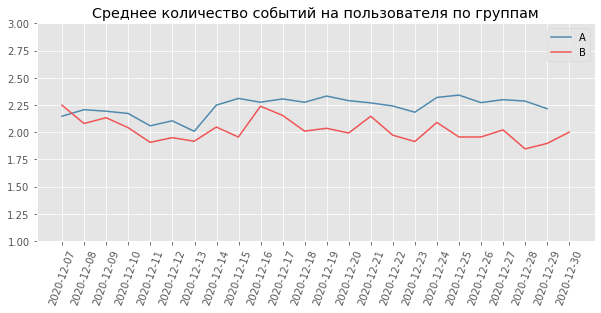

In [168]:
# Выделим дату в отдельное поле в таблице с событиями:
test_events['date'] = test_events['event_dt'].dt.date

t = test_events.groupby(['user_id', 'date', 'group']).agg(events = ('event_name', 'count'))
tt = t.pivot_table(index='date',
              columns='group',
              values='events',
              aggfunc='mean'
             ).reset_index()

dates = pd.date_range(test_events['event_dt'].min(), test_events['event_dt'].max(), freq='D')

plt.figure(figsize=(10, 4))
plt.ylim((1, 3))
plt.title('Среднее количество событий на пользователя по группам')
sns.lineplot(x='date', y='A', data=tt, label='A', color='#4e89ae')
sns.lineplot(x='date', y='B', data=tt, label='B', color='#f05454')
plt.xlabel('')
plt.ylabel('')
plt.xticks(dates, rotation=70)
plt.legend()
plt.show()

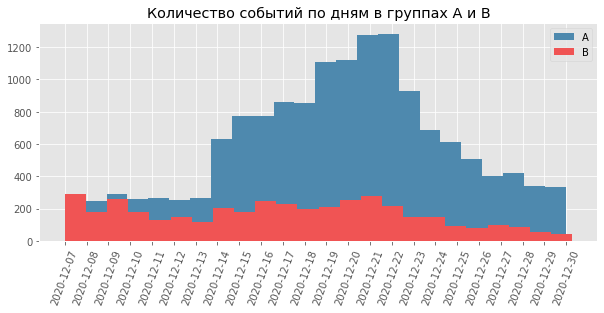

In [169]:
# Построим гистограмму событий по дням:
plt.style.use('ggplot')

plt.title('Количество событий по дням в группах А и В')
test_events[test_events['group'] == 'A']['event_dt'].hist(bins=len(dates),  figsize=(10, 4), color = '#4e89ae', label = 'A')
test_events[test_events['group'] == 'B']['event_dt'].hist(bins=len(dates),  figsize=(10, 4), color = '#f05454', label = 'B')
plt.xticks(dates, rotation=70)
plt.legend()
plt.show()

* Число событий распределено по дням не равномерно.
* Учитывая, что среднее количество событий на пользователя по группам А и В различается не сильно, подъём графика А в 20-х числах декабря свидетельствует о кумулятивном увеличении количества пользователей, приписанных к данной тестовой группе.

Посмотрим распределение количества событий на пользователя по группам.

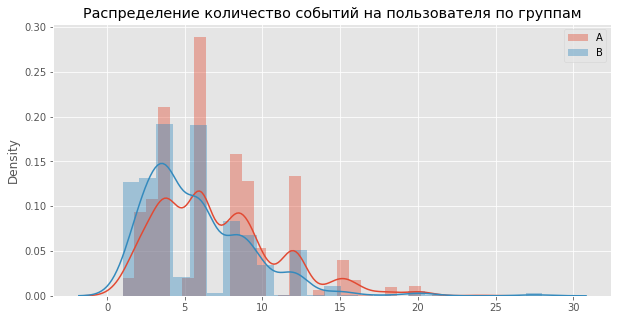

In [170]:
events_A = test_events[test_events['group']=='A'].groupby('user_id').agg(events = ('event_name', 'count'))
events_B = test_events[test_events['group']=='B'].groupby('user_id').agg(events = ('event_name', 'count'))

plt.figure(figsize=(10,5))
plt.title('Распределение количество событий на пользователя по группам')
sns.distplot(events_A['events'], label='A')
sns.distplot(events_B['events'], label='B')
plt.legend()
plt.xlabel('')
plt.show()

* Распределения групп А и В скошены вправо, что ожидаемо - редкие пользователи совершают много действий в приложении.
* Прослеживается некоторая кратность в распределениях - покупка часто включает определённое количество событий.

# 5. Оценка результатов A/B-тестирования. Проверка гипотез 

* В системе не прослеживается ожидаемая последовательность событий Авторизация -> Просмотр товара -> Просмотр корзины -> Покупка.
* Практически все события Покупки сопровождаются одновременным событием Авторизации и далее следует либо Просмотр товара, либо Просмотр корзины.
* Но не с каждой Авторизацией/Просмотром товара/Просмотром корзины совершалась покупка - конверсию в эти шаги мы и тестировали - группа В продемонстрировала более скромные результаты по сравнению с группой А.

Определим, есть ли статистически значимая разница между долями прошедших по воронке пользователей в группах А и В.

Перед проверкой гипотезы о равенстве долей очистим данные от выбросов - исключим пользователей с аномально большим числом событий.

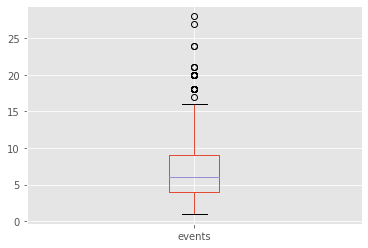

In [171]:
events_count = test_events.groupby('user_id').agg(events=('event_name', 'count'))
events_count.boxplot()
plt.show()


Исключим пользователей с числом событий > 16:

In [172]:
events_count = events_count.reset_index()
big_users = events_count[events_count['events'] > 16]['user_id']

print('Пользователей с аномальным числом действий:', len(big_users))
print('Всего пользователей в ивентах до удаления выбросов:', len(test_events['user_id'].unique()))
test_events = test_events[~test_events['user_id'].isin(big_users)]
print('Всего пользователей в ивентах после удаления выбросов:', len(test_events['user_id'].unique()))

Пользователей с аномальным числом действий: 47
Всего пользователей в ивентах до удаления выбросов: 2788
Всего пользователей в ивентах после удаления выбросов: 2741


Итак, нам необходимо проверить три гипотезы о равенстве долей в группах А и В при конверсии в:

* Просмотр карточек товаров (product_page)
* Просмотр корзины (product_cart)
* Покупку (purchase)

Поскольку тестов у нас три, проведем коррекцию уровня значимости методом Бонферрони:

In [173]:
alpha = 0.05
alpha = alpha / 3

In [174]:
def z_test(event_1, event_2):
    """
    Функция проверяет z-критерием статистическую разницу долей в группах А и В при конверсии из шага `event_1` в шаг `event_2`.
    Входные параметры:
    `event_1` - шаг 1 воронки
    `event_2` - шаг 2 воронки     
    """
    rep = test_events.query('event_name == @event_1 | event_name == @event_2').pivot_table(index='group', 
                                                                                      columns='event_name', 
                                                                                      values='user_id',
                                                                                      aggfunc='nunique')
    rep['conversion'] = rep[event_2] / rep[event_1]
    display(rep)
    
    count = list(rep[event_2].values)
    nobs = list(rep[event_1].values)
    
    pvalue = proportions_ztest(count, nobs, value = 0)[1]
    print('p-value: {}'.format(pvalue))
    if pvalue >= alpha: 
        print(colored('Нулевая гипотеза не отвергается: между группами A и B нет различий в % конверсии в событие "' + event_2 + '"', 'red'))
    else: 
        print(colored('Нулевая гипотеза отвергается: между группами A и B есть различие в % конверсии в событие "' + event_2 + '"', 'green'))


**Процент конвертации в Просмотр карточки товаров**

H0: Между группами A и B нет различий в % конверсии в покупку
 
H1: Между группами A и B есть различие % конверсии в покупку

In [175]:
z_test('login', 'product_page')

event_name,login,product_page,conversion
group,,,
A,2043,1321,0.646598
B,698,390,0.558739


p-value: 3.50812154178242e-05
Нулевая гипотеза отвергается: между группами A и B есть различие в % конверсии в событие "product_page"


**Процент конвертации в Просмотр корзины**

H0: Между группами A и B нет различий в % конверсии в просмотр корзины

H1: Между группами A и B есть различие % конверсии в просмотр корзины

In [176]:
z_test('login', 'product_cart')

event_name,login,product_cart,conversion
group,,,
A,2043,599,0.293196
B,698,188,0.269341


p-value: 0.22909839116637054
Нулевая гипотеза не отвергается: между группами A и B нет различий в % конверсии в событие "product_cart"


Процент конвертации в Покупку

H0: Между группами A и B нет различий в % конверсии в покупку

H1: Между группами A и B есть различие % конверсии в покупку

In [177]:
z_test('login', 'purchase')

event_name,login,purchase,conversion
group,,,
A,2043,625,0.305923
B,698,191,0.273639


p-value: 0.10730616779100727
Нулевая гипотеза не отвергается: между группами A и B нет различий в % конверсии в событие "purchase"


# 6. Выводы


При проверке корректности проведения теста были выявлены следующие нарушения:

1. Параллельно с целевым тестом шёл другой масштабный тест. После исключения из анализа участников, попавших в оба теста, всего осталось 5099 пользователей, что на 15% меньше от запланированного количества.
2. В выгрузке не хватает данных о событиях с 31.12.2020 по 04.01.2021 (время остановки теста). Нет информации за 5 из 28 запланированных дней - почти 18% данных не доступны для анализа.
3. Количество участников в группах А и В сильно различается (2903 и 2196, соответственно).
4. Аудитория теста составила 10% новых пользователей из целевого региона против запланированных 15%.
5. Почти половина пользователей теста (45.3%) не совершили ни одного действия в системе. Активных пользователей в группе А оказалось почти в 3 раза больше, чем в группе В (2082 против 706).
6. После набора пользователей, но до остановки теста, в период с 25.12.2020 по 03.01.2021гг. в целевом регионе проводилась акция "Christmas&New Year Promo".

В ходе исследовательского анализа имеющихся данных установлены следующие особенности:

* В системе не прослеживается ожидаемая последовательность событий Авторизация -> Просмотр товара -> Просмотр корзины -> Покупка.
* Практически все события Покупки сопровождаются одновременным событием Авторизации и далее следует либо Просмотр товара, либо Просмотр корзины - возможно, так работает опция "Быстрая покупка". В таком случае, почти все покупки были совершены по упрощённой схеме.

Результаты проверки гипотезы о равенстве долей свидетельствуют:

* о проигрыше группы В при конверсии в Просмотр товара.
* об отсутствии разницы между группами А и В при конверсии в Просмотр корзины и Покупку.

**Таким образом, судя по имеющимся данным, новая рекомендательная система целевые метрики не улучшила**. Однако, для получения достоверной оценки необходимо провести корректный А/В-тест.
